In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from amg_utils import amg_limits

In [2]:
model = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")
amgs = json.loads(open("model_files/amg_reactions.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())

In [3]:
def plot_impact_graph(
    ax, fva_healthy, fva_phm2, amgs, cut=0.1, sort=True, highlights=None
):
    diffs = fva_phm2 - fva_healthy
    if sort:
        diff_s = sorted(
            diffs.iterrows(),
            key=lambda x: -np.abs(
                (fva_healthy.loc[x[0], "maximum"] + fva_healthy.loc[x[0], "minimum"])
                / 2
                - (fva_phm2.loc[x[0], "maximum"] + fva_phm2.loc[x[0], "minimum"]) / 2
            )
            if x[0] != "PHM2_prodrxn_VN"
            else 1,
        )
    else:
        diff_s = diffs.iterrows()
    barw = 0.85
    ylabs = []
    scales = []
    row = 0
    for i, (dind, (dmin, dmax)) in enumerate(diff_s):
        r_healthy = fva_healthy[fva_healthy.index == dind]
        if r_healthy.empty:
            continue
        hmin = float(r_healthy["minimum"].iloc[0])
        hmax = float(r_healthy["maximum"].iloc[0])
        hwidth = hmax - hmin

        r_infected = fva_phm2[fva_phm2.index == dind]
        imin = float(r_infected["minimum"].iloc[0])
        imax = float(r_infected["maximum"].iloc[0])
        iwidth = imax - imin

        normalization = max([np.abs(hmin), np.abs(hmax), np.abs(imin), np.abs(imax)])

        if normalization < cut:
            continue

        hmin /= normalization
        hmax /= normalization
        hwidth /= normalization
        imin /= normalization
        imax /= normalization
        iwidth /= normalization
        dmin /= normalization
        dmax /= normalization

        hmid = (hmin + hmax) / 2
        imid = (imin + imax) / 2

        if np.abs(hmid - imid) < cut:
            continue

        ax.broken_barh(
            [(hmin, hwidth)],
            (-row - 0.5, barw),
            color="b",
            alpha=0.2,
        )
        ax.plot(hmid, -row, "bo", alpha=0.5)

        ax.broken_barh(
            [(imin, iwidth)],
            (-row - 0.5, barw),
            color="r",
            alpha=0.2,
        )
        ax.plot(imid, -row, "ro", alpha=0.5)

        if highlights and dind in highlights:
            lb, ub = highlights[dind]
            hlb = lb / normalization
            hub = ub / normalization
            ax.broken_barh(
                [(hlb, hub - hlb)],
                (-row - 0.5, barw),
                color="k",
                alpha=0.25,
            )
            ax.plot((hlb + hub) / 2, -row, "ko", alpha=0.5)

        row += 1
        ss = healthy.reactions.get_by_id(dind).subsystem
        # nm = healthy.reactions.get_by_id(dind).name
        nm = dind
        if not ss:
            ss = "Unspecified"
        if ss in manual_relabels:
            ss = manual_relabels[ss]
        ylabs.append(f"{'*' if nm in amgs else ''}{nm} ({ss})")
        if normalization > 0.01:
            scales.append(f"x{normalization:.2f} " + r"mmol gDW$^{-1}$h$^{-1}$")
        else:
            scales.append(f"x{normalization:.2e} " + r"mmol gDW$^{-1}$h$^{-1}$")
    ax.set_yticks([-x for x in range(len(ylabs))])
    ax.set_yticklabels(ylabs)
    ax2 = ax.twinx()
    ax2.set_yticks([-x for x in range(len(ylabs))])
    ax2.set_yticklabels(scales)
    ax.set_ylim([-len(ylabs), 1])
    ax2.set_ylim([-len(ylabs), 1])
    ax.grid(axis="both")
    ax.set_xlabel("FVA Ranges (normalized)")
    if highlights:
        ax.legend(
            [
                "Healthy Range",
                "Healthy Midpoint",
                "Infected Range",
                "Infected Midpoint",
                "AMG Target Range",
                "AMG Target Midpoint",
            ],
            ncols=3,
            loc="upper right",
        )
    else:
        ax.legend(
            [
                "Healthy Range",
                "Healthy Midpoint",
                "Infected Range",
                "Infected Midpoint",
            ],
            ncols=2,
            loc="upper right",
        )

In [4]:
with model as healthy:
    fva_healthy = cobra.flux_analysis.flux_variability_analysis(healthy)
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg = cobra.flux_analysis.flux_variability_analysis(phm2)
print(fva_healthy[fva_healthy.index == "BIOMASS"])
print(fva_healthy[fva_healthy.index == "PHM2_prodrxn_VN"])
print("-" * 80)
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "BIOMASS"])
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "PHM2_prodrxn_VN"])

          minimum   maximum
BIOMASS  0.098462  0.098462
                 minimum       maximum
PHM2_prodrxn_VN      0.0  1.225289e-14
--------------------------------------------------------------------------------
         minimum       maximum
BIOMASS      0.0 -3.601452e-13
                  minimum   maximum
PHM2_prodrxn_VN  0.183896  0.183896


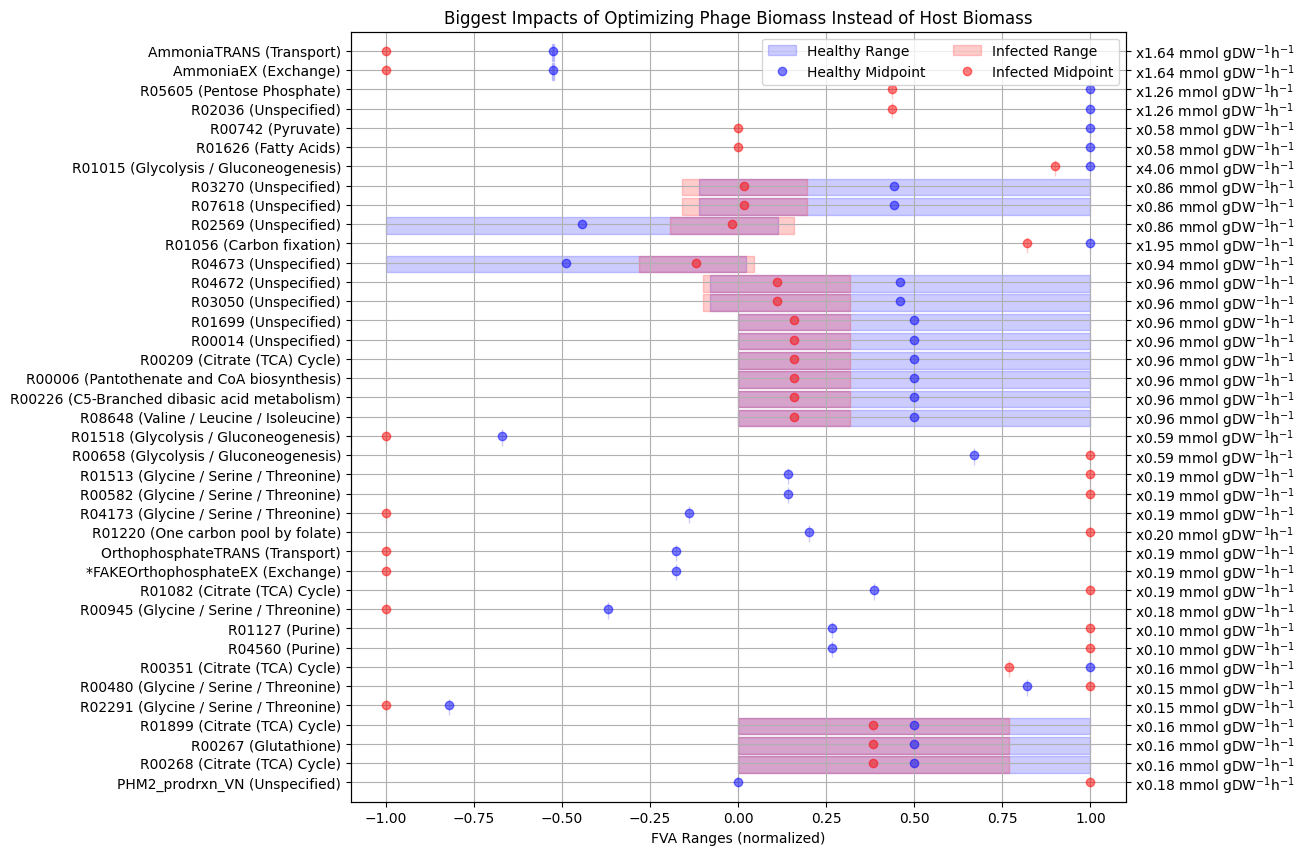

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(ax, fva_healthy, fva_phm2_no_amg, amgs, cut=0.1)
ax.set_title("Biggest Impacts of Optimizing Phage Biomass Instead of Host Biomass")
plt.show()

In [6]:
with model as healthy:
    fva_healthy_amg = cobra.flux_analysis.flux_variability_analysis(
        healthy, list(amgs.keys())
    )
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg_amg = cobra.flux_analysis.flux_variability_analysis(
        phm2, list(amgs.keys())
    )

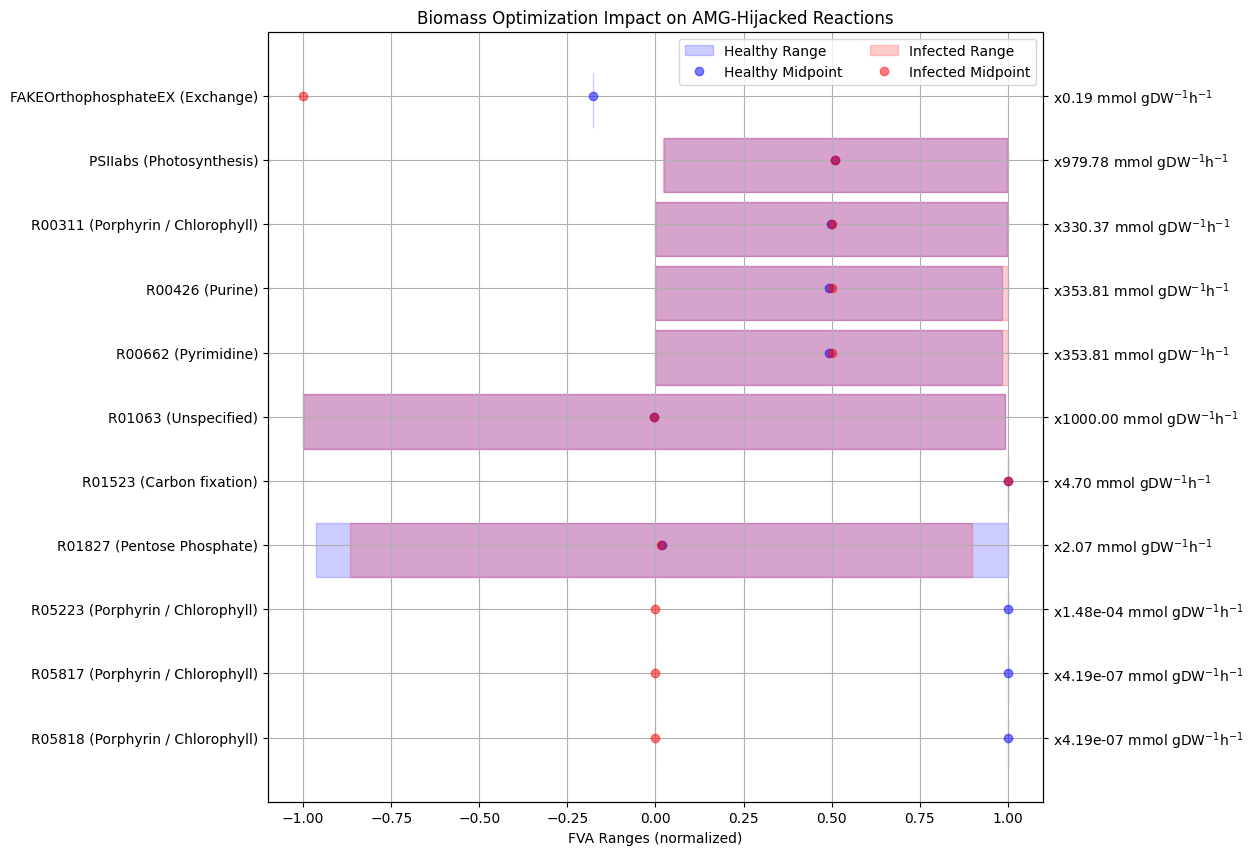

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(ax, fva_healthy_amg, fva_phm2_no_amg_amg, [], cut=0, sort=False)
ax.set_title("Biomass Optimization Impact on AMG-Hijacked Reactions")
plt.show()

In [8]:
# For some ridiculous reason, this is both faster and more numerically
# consistent that using the built-in reaction list feature...
h1 = {}
h2 = {}
i1 = {}
i2 = {}
for amg in amgs:
    with model as healthy:
        res = cobra.flux_analysis.flux_variability_analysis(
            healthy,
            [amg],
            fraction_of_optimum=0.5,
        )

    h1[amg] = res["minimum"][amg]
    h2[amg] = res["maximum"][amg]

    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        res = cobra.flux_analysis.flux_variability_analysis(
            phm2,
            [amg],
            fraction_of_optimum=0.5,
        )
    i1[amg] = res["minimum"][amg]
    i2[amg] = res["maximum"][amg]
fva_healthy_amg2 = pd.DataFrame({"minimum": h1, "maximum": h2})
fva_phm2_amg2 = pd.DataFrame({"minimum": i1, "maximum": i2})

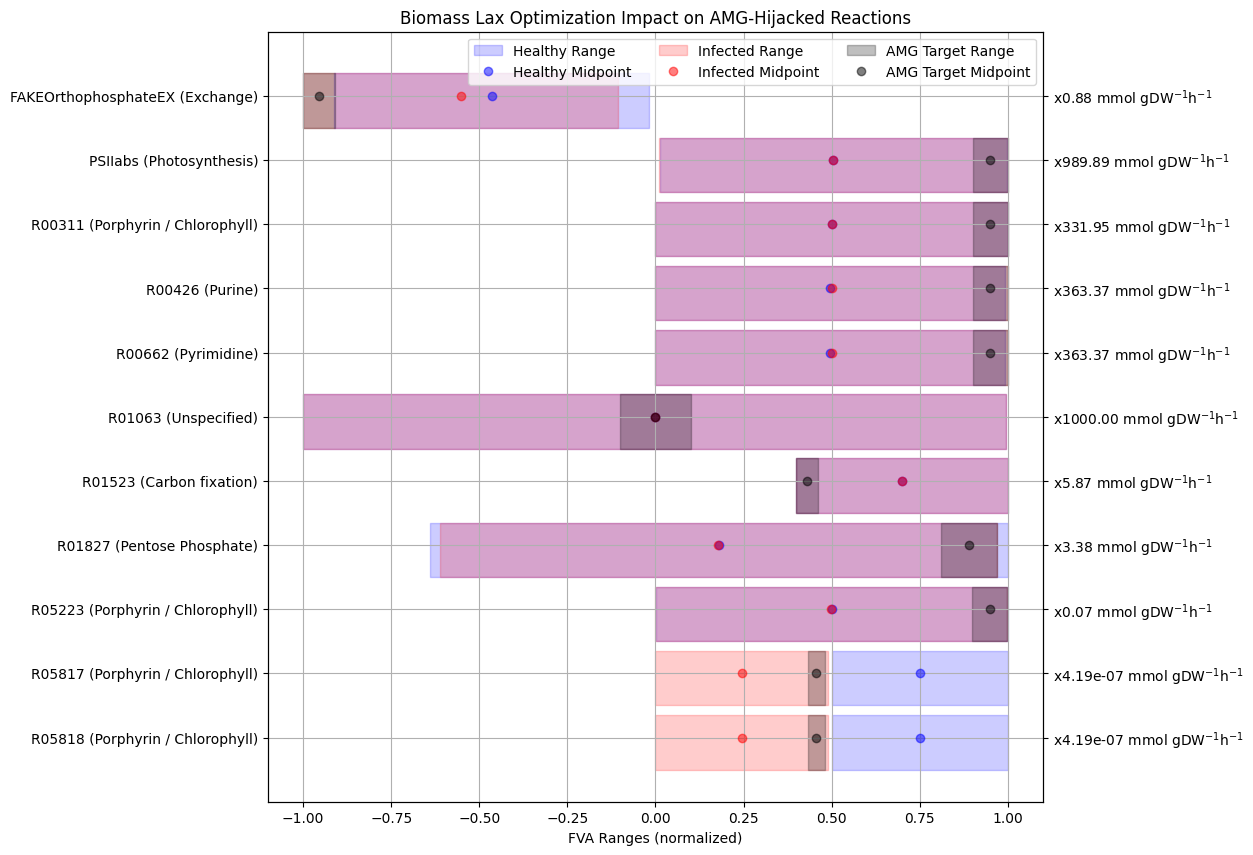

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
highlights = {}
for i, (amg, direction) in enumerate(amgs.items()):
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.5, tol=0.1)
    highlights[amg] = (lb, ub)

plot_impact_graph(
    ax,
    fva_healthy_amg2,
    fva_phm2_amg2,
    [],
    cut=0,
    sort=False,
    highlights=highlights,
)


ax.set_title("Biomass Lax Optimization Impact on AMG-Hijacked Reactions")
plt.show()

In [10]:
amg_new_vals = {}
for amg, direction in amgs.items():
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.5, tol=0.1)
    amg_new_vals[amg] = (lb + ub) / 2
amg_new_vals

{'FAKEOrthophosphateEX': np.float64(-0.8378580935670241),
 'PSIIabs': np.float64(940.8959434104111),
 'R00311': np.float64(315.35381478701333),
 'R00426': np.float64(345.2020865248845),
 'R00662': np.float64(345.20208652488446),
 'R01063': np.float64(0.0),
 'R01523': np.float64(2.5262500000001102),
 'R01827': np.float64(3.012405245444948),
 'R05223': np.float64(0.07087301587301495),
 'R05817': np.float64(1.9110132487691267e-07),
 'R05818': np.float64(1.911013248769127e-07)}

In [11]:
amg_fvas = {}
for amg, new_val in amg_new_vals.items():
    with model as phm2:
        phm2.reactions.get_by_id(amg).bounds = new_val, new_val
        fva_phm2 = cobra.flux_analysis.flux_variability_analysis(phm2)
    amg_fvas[amg] = fva_phm2.copy()


In [12]:
hmid = (fva_healthy["maximum"] + fva_healthy["minimum"]) / 2
mdiffs = {}
for amg, fva in sorted(amg_fvas.items()):
    mids = (fva["maximum"] + fva["minimum"]) / 2
    mid_diff = mids - hmid
    mdiffs[amg] = mid_diff
mdf = pd.DataFrame(mdiffs)

In [13]:
mdf_filtered = mdf[mdf.abs().max(axis=1) >= 0.05].apply(lambda x: x)
mdf_filtered["Phage Biomass"] = (
    fva_phm2_no_amg["maximum"] + fva_phm2_no_amg["minimum"]
) / 2 - hmid

mdf_filtered = mdf_filtered.sort_index(
    axis=0,
    key=lambda x: [model.reactions.get_by_id(y).subsystem for y in x],
)
last = ""
switch_inds = [(0, "Unspecified")]
for i, (rxn, row) in enumerate(mdf_filtered.iterrows()):
    ss = model.reactions.get_by_id(rxn).subsystem
    if last != ss:
        last = ss
        if ss in manual_relabels:
            ss = manual_relabels[ss]
        switch_inds.append((i, ss))
switch_inds

[(0, 'Unspecified'),
 (96, 'Alanine, aspartate and glutamate metabolism'),
 (101, 'Arginine / Proline'),
 (113, 'Biomass'),
 (115, 'Biotin metabolism'),
 (129, 'Butanoate metabolism'),
 (130, 'C5-Branched dibasic acid metabolism'),
 (131, 'Carbon fixation'),
 (141, 'Citrate (TCA) Cycle'),
 (148, 'Cysteine and methionine metabolism'),
 (157, 'Exchange'),
 (206, 'Fake Transport Reaction'),
 (215, 'Fatty Acids'),
 (216, 'Folate biosynthesis'),
 (227, 'Glutathione'),
 (233, 'Glycerolipids'),
 (236, 'Glycine / Serine / Threonine'),
 (255, 'Glycolysis / Gluconeogenesis'),
 (265, 'Histidine'),
 (273, 'Lysine biosynthesis'),
 (277, 'Lysine degradation'),
 (278, 'Nicotinate / Nicotinamide'),
 (285, 'Nitrogen metabolism'),
 (290, 'One carbon pool by folate'),
 (296, 'Oxidative Phosphorylation'),
 (309, 'Pantothenate and CoA biosynthesis'),
 (315, 'Pentose Phosphate'),
 (321, 'Phenylalanine / Tyrosine / Tryptophan'),
 (340, 'Photorespiration'),
 (342, 'Photosynthesis'),
 (352, 'Porphyrin / Chloro

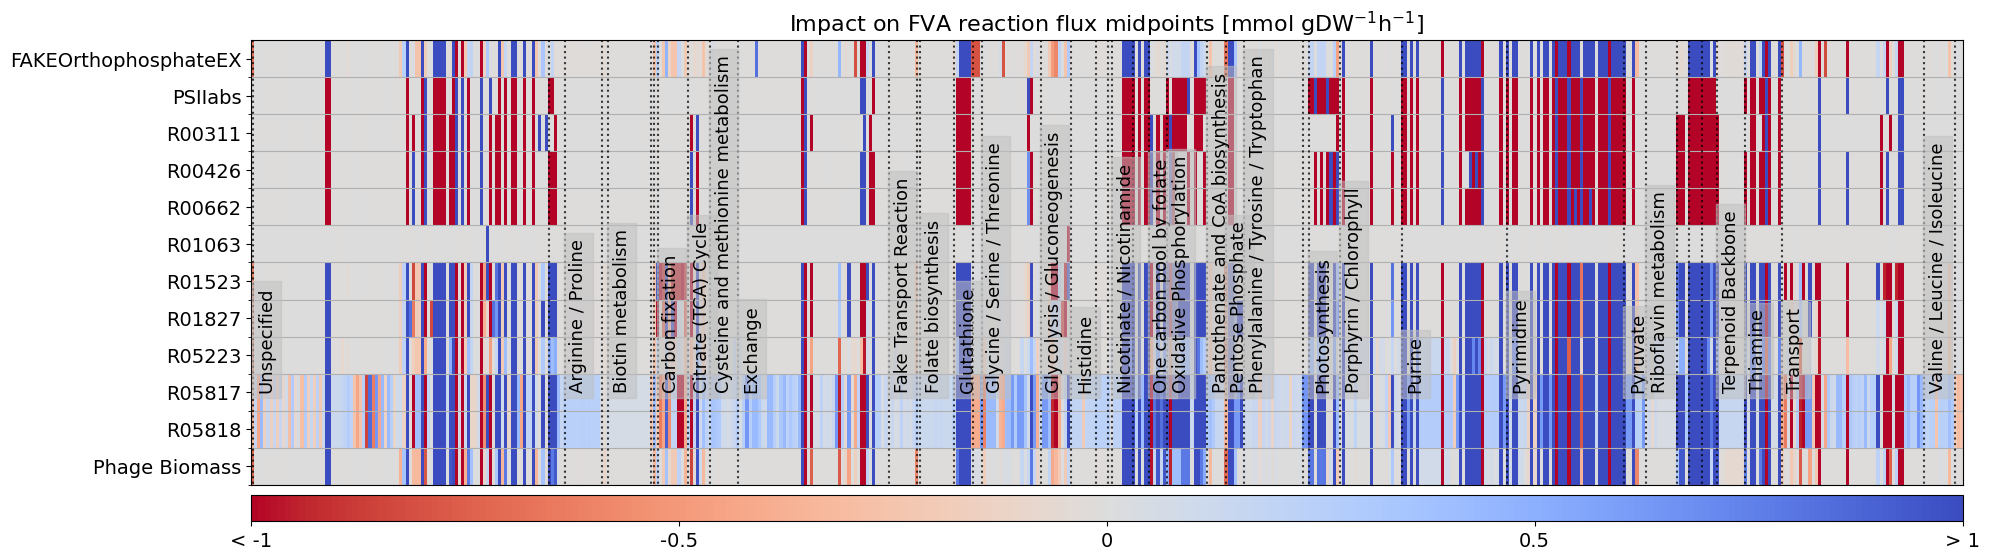

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = ax.matshow(
    mdf_filtered.T,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1,
    aspect=12,
    interpolation="none",
)
ticks = range(1 + len(sorted(amgs.keys())))

ax.set_yticks(ticks, minor=False)
ax.set_yticks([0.5 + x for x in ticks], minor=True)
ax.set_yticklabels(sorted(amgs.keys()) + ["Phage Biomass"], fontsize=14)
ax.set_xticks([])
ax.grid(True, which="minor")
ax.set_title(
    "Impact on FVA reaction flux midpoints " + r"[mmol gDW$^{-1}$h$^{-1}$]", fontsize=16
)
cbar = fig.colorbar(
    im,
    aspect=64,
    orientation="horizontal",
    pad=0.01,
)
cbar.set_ticks(
    ticks=[-1, -0.5, 0, 0.5, 1],
    labels=["< -1", "-0.5", "0", "0.5", "> 1"],
    fontsize=14,
)


for line, (i, ss) in enumerate(switch_inds):
    if ss == "":
        ss = "Unspecified"
    ax.vlines(i, -0.5, 11.5, linestyles="dotted", color="black", alpha=0.75)
    if (line < len(switch_inds) - 1) and switch_inds[line + 1][0] - i > 5:
        ax.text(
            i + 1.5,
            9.0,
            ss,
            horizontalalignment="left",
            verticalalignment="bottom",
            fontsize=13,
            rotation=90,
            color="black",
            alpha=1,
            backgroundcolor="#c0c0c088",
        )


fig.tight_layout()
# fig.savefig("phage_barcode.png")
plt.show()

In [15]:
from sklearn.decomposition import PCA

pcadf = pd.concat([mdf.iloc[:, 0] * 0, mdf], axis=1)
pcadf.columns = ["No AMG"] + list(mdf.columns)
pcadf
df_normalized = ((pcadf - pcadf.mean()) / pcadf.std()).fillna(0)

pca = PCA(n_components=pcadf.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC%s" % _ for _ in range(len(df_normalized.columns))],
    index=pcadf.columns,
)
loadings

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
No AMG,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,1.0,-0.000000e+00
FAKEOrthophosphateEX,3.291636e-01,-2.231644e-13,1.222723e-01,3.368826e-02,2.826114e-01,3.295539e-01,-6.522937e-01,7.465772e-02,-5.046827e-01,-3.640684e-02,0.0,-2.761854e-13
PSIIabs,-3.140987e-01,-1.105613e-11,-1.486224e-01,-6.095562e-01,5.235884e-01,4.202568e-01,2.339417e-01,-4.115269e-02,-2.201148e-02,-5.222603e-03,0.0,8.023768e-13
R00311,-1.827414e-01,8.991012e-12,9.734469e-01,-1.184107e-01,9.165233e-03,-9.964774e-03,6.481387e-02,3.592227e-03,2.422782e-02,-1.259831e-03,0.0,2.441588e-13
R00426,-3.226858e-01,5.222768e-12,-4.335470e-03,4.191346e-01,-3.675129e-01,7.518427e-01,1.108269e-01,-6.826734e-02,-5.033686e-02,-1.926860e-02,0.0,-3.787512e-13
R00662,-3.146603e-01,3.346452e-12,6.110844e-03,6.435543e-01,6.719717e-01,-1.735561e-01,6.932428e-02,1.064614e-02,1.393719e-02,2.874044e-03,0.0,5.946233e-13
R01063,1.746820e-12,1.000000e+00,-1.025302e-11,-9.862573e-12,5.822156e-12,2.436797e-12,8.229007e-13,3.731389e-12,1.880201e-12,1.995106e-13,0.0,-2.494906e-14
R01523,3.339797e-01,9.348364e-13,6.288438e-02,6.737864e-02,1.133094e-01,1.301156e-01,1.265873e-01,-4.386438e-01,1.001390e-01,7.948167e-01,0.0,1.147288e-12
R01827,3.322037e-01,-2.646609e-13,4.088420e-02,8.231865e-02,1.447861e-02,1.703760e-03,6.614277e-01,3.580420e-01,-5.614108e-01,1.083854e-02,0.0,-1.296829e-13
R05223,3.327599e-01,-4.453140e-12,5.518831e-02,6.336403e-02,1.457111e-01,2.813549e-01,-1.361485e-02,6.391975e-01,6.076328e-01,6.197870e-02,0.0,2.452607e-13


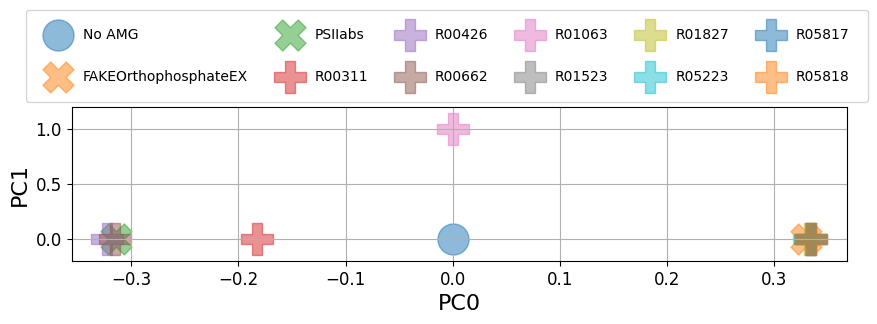

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
for i, row in loadings.iterrows():
    x = row["PC0"]
    y = row["PC1"]
    ax.scatter(
        x,
        y,
        label=i,
        marker="P" if i.startswith("R") else "o" if i == "No AMG" else "X",
        s=500,
        alpha=0.5,
    )
ax.grid(True)
ax.tick_params(axis="both", which="both", labelsize=12)
ax.set_xlabel("PC0", fontsize=16)
ax.set_ylabel("PC1", fontsize=16)
fig.legend(
    ncols=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.4),
    fontsize=10,
    labelspacing=2,
    borderpad=1.3,
)

ax.set_ylim([-0.2, 1.2])
plt.show()